In [61]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import warnings
from scipy.stats import zscore, mode
from sklearn.metrics import (silhouette_samples,silhouette_score,make_scorer,mean_absolute_error, r2_score, mean_squared_error,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score)
from sklearn.base import (BaseEstimator,TransformerMixin,ClassifierMixin,RegressorMixin)
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, BaseCrossValidator, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import joblib
from joblib import load
import os
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans, silhouette_score as ts_silhouette_score
import shap
from lime import lime_tabular
from sklearn.model_selection import GroupKFold

In [62]:
# Cargar los datos desde el archivo Excel
file_path = 'C:/Users/Andy/OneDrive/Desktop/MCD/Tesis/Datos_fuente_Bloomberg/en valores/serie completa 2014-2024/Dataset/dataset_completo.xlsx'
df = pd.read_excel(file_path, sheet_name='dataset')

In [63]:
df.head()

,Empresa,Fecha,P_E,P_B,P_TB,P_S,P_CF,P_FCF,P_Share,ROCE_sp,...,Efectivo y equiv_l,CPI,CPI_Exp_mediana,CPI_Exp_promedio,Fed Funds Rate,Fed Funds Rate_Exp_mediana,Fed Funds Rate_Exp_promedio,Non farm payrolls,Non farm payrolls_Exp_mediana,Non farm payrolls_Exp_promedio
0,FLWS US Equity,20140930,31.7207,2.5643,6.1415,0.6062,10.3190,21.6093,7.19,5.886400,...,1.314000,1.7,0.019,0.0191,0.25,0.0025,0.0025,307,230k,226.13k
1,FLWS US Equity,20141031,35.4266,2.8638,6.859,0.677,11.5246,24.1339,8.03,8.881198,...,2.610333,1.7,0.016,0.0162,0.25,0.0025,0.0025,240,215k,216.22k
2,FLWS US Equity,20141128,37.7207,3.0493,7.3032,0.7208,12.2709,25.6967,8.55,9.469145,...,3.906667,1.3,0.016,0.0157,0.25,0.0025,0.0025,284,235k,236.62k
3,FLWS US Equity,20141231,11.3711,2.3843,8.1913,0.5153,2.6214,3.0449,8.24,8.721900,...,5.203000,0.8,0.014,0.0142,0.25,0.0025,0.0025,278,230k,229.16k
4,FLWS US Equity,20150130,10.8881,2.283,7.8433,0.4934,2.5100,2.9155,7.89,7.711122,...,4.188000,-0.1,0.007,0.0069,0.25,0.0025,0.0025,196,240k,234.73k


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166440 entries, 0 to 166439
Data columns (total 42 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Empresa                         166440 non-null  object 
 1   Fecha                           166440 non-null  int64  
 2   P_E                             87792 non-null   float64
 3   P_B                             119348 non-null  object 
 4   P_TB                            92514 non-null   object 
 5   P_S                             117703 non-null  object 
 6   P_CF                            95713 non-null   float64
 7   P_FCF                           69291 non-null   object 
 8   P_Share                         131345 non-null  object 
 9   ROCE_sp                         115613 non-null  float64
 10  ROCE_l                          115613 non-null  float64
 11  EBIT_sp                         115176 non-null  float64
 12  EBIT_l          

In [65]:
# Quitar "k" de las columnas "Non farm payrolls_Exp_mediana" y "Non farm payrolls_Exp_promedio"
df['Non farm payrolls_Exp_mediana'] = df['Non farm payrolls_Exp_mediana'].astype(str).str.replace('k', '')
df['Non farm payrolls_Exp_promedio'] = df['Non farm payrolls_Exp_promedio'].astype(str).str.replace('k', '')

# Convertir las columnas a valores numéricos
df['Non farm payrolls_Exp_mediana'] = pd.to_numeric(df['Non farm payrolls_Exp_mediana'], errors='coerce')
df['Non farm payrolls_Exp_promedio'] = pd.to_numeric(df['Non farm payrolls_Exp_promedio'], errors='coerce')
df['P_B'] = pd.to_numeric(df['P_B'], errors='coerce')
df['P_TB'] = pd.to_numeric(df['P_TB'], errors='coerce')
df['P_S'] = pd.to_numeric(df['P_S'], errors='coerce')
df['P_FCF'] = pd.to_numeric(df['P_FCF'], errors='coerce')
df['P_Share'] = pd.to_numeric(df['P_Share'], errors='coerce')

In [66]:
# Convertir la columna de fecha a formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y%m%d')

# Extraer características temporales relevantes
df['mes'] = df['Fecha'].dt.month
df['año'] = df['Fecha'].dt.year
df['periodo'] = df['Fecha'].dt.to_period('M')

In [67]:
# Convertir CPI y Fed Funds Rate a decimales
df['CPI'] = df['CPI'] / 100
df['Fed Funds Rate'] = df['Fed Funds Rate'] / 100

In [68]:
# Calcular diferencias en puntos básicos
df['dif_CPI_mediana'] = (df['CPI'] - df['CPI_Exp_mediana']) * 10000
df['dif_CPI_promedio'] = (df['CPI'] - df['CPI_Exp_promedio']) * 10000

df['dif_FFR_mediana'] = (df['Fed Funds Rate'] - df['Fed Funds Rate_Exp_mediana']) * 10000
df['dif_FFR_promedio'] = (df['Fed Funds Rate'] - df['Fed Funds Rate_Exp_promedio']) * 10000

# Calcular diferencia
df['dif_NFP_mediana'] = (df['Non farm payrolls'] - df['Non farm payrolls_Exp_mediana'])
df['dif_NFP_promedio'] = (df['Non farm payrolls'] - df['Non farm payrolls_Exp_promedio'])

In [69]:
# tickers financieros (GICS)
gics_financieras = r'C:\Users\Andy\OneDrive\Desktop\MCD\Tesis\Datos_fuente_Bloomberg\GICS_Finanzas.xlsx'
try:
    df_tickers_financieras = pd.read_excel(gics_financieras)
    columna_ticker_excel = 'Ticker de miembro'
    columna_ticker_df = 'Ticker de miembro'

    if columna_ticker_excel not in df_tickers_financieras.columns:
        raise ValueError(f"La columna '{columna_ticker_excel}' no se encuentra en el archivo Excel.")

    # Seleccionar solo la columna de tickers y renombrarla si es necesario para el merge
    df_tickers_financieras = df_tickers_financieras[[columna_ticker_excel]].rename(columns={columna_ticker_excel: columna_ticker_df})
    # Eliminar duplicados por si acaso
    df_tickers_financieras = df_tickers_financieras.drop_duplicates().reset_index(drop=True)

    print(f"Se cargaron {len(df_tickers_financieras)} tickers del sector financiero.")
    print(df_tickers_financieras.head())

except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{gics_financieras}'")
    # Detener o manejar el error
except ValueError as ve:
     print(f"Error al procesar el Excel: {ve}")
     # Detener o manejar el error
except Exception as e:
    print(f"Ocurrió un error inesperado al leer el Excel: {e}")
    # Detener o manejar el error

Se cargaron 6271 tickers del sector financiero.
  Ticker de miembro
0   BRK/A US Equity
1    8109 HK Equity
2     JPM US Equity
3  601398 CH Equity
4    1288 HK Equity


In [70]:
columna_ticker_df_en_principal = 'Empresa' 
# -------------------------------------------------------------------------

print(f"\nFiltrando el DataFrame principal ('df') para tickers financieros...")
print(f"Se usarán los tickers de la columna '{df_tickers_financieras.columns[0]}' del archivo Excel.")
print(f"Se buscarán coincidencias en la columna '{columna_ticker_df_en_principal}' del DataFrame principal.")

# Obtener la lista única de tickers financieros cargados
tickers_financieros_lista = df_tickers_financieras[df_tickers_financieras.columns[0]].unique()

# Verificar que la columna exista en df
if columna_ticker_df_en_principal not in df.columns:
    print(f"ERROR: La columna '{columna_ticker_df_en_principal}' no existe en el DataFrame principal 'df'.")
    print(f"Columnas disponibles en 'df': {df.columns.tolist()}")
    # Detener o manejar el error
    # df_financieras_completo = pd.DataFrame() # Crear df vacío para evitar errores posteriores
else:
    # Filtrar df usando la lista de tickers
    # Usamos .isin() para encontrar filas donde el ticker en df está en nuestra lista
    df_financieras_completo = df[df[columna_ticker_df_en_principal].isin(tickers_financieros_lista)].copy()

    num_empresas_filtradas = df_financieras_completo[columna_ticker_df_en_principal].nunique()
    print(f"\nDataFrame filtrado ('df_financieras_completo') contiene:")
    print(f"  - {len(df_financieras_completo)} filas")
    print(f"  - {num_empresas_filtradas} empresas financieras únicas.")

    if df_financieras_completo.empty:
        print("\n¡ADVERTENCIA! El DataFrame filtrado está vacío.")
        print("Posibles causas:")
        print("  - No hay coincidencias entre los tickers del Excel y los tickers en la columna "
              f"'{columna_ticker_df_en_principal}' de 'df'.")
        print("  - Verifica los formatos de los tickers (ej. 'AAPL' vs 'AAPL US Equity').")
        print("  - Verifica que el nombre de la columna en 'df' sea correcto.")
    else:
        print("\nPrimeras filas del DataFrame filtrado ('df_financieras_completo'):")
        print(df_financieras_completo.head())
        print("\nÚltimas filas del DataFrame filtrado ('df_financieras_completo'):")
        print(df_financieras_completo.tail())

# --- LISTO PARA EL SIGUIENTE PASO ---
# Ahora puedes usar 'df_financieras_completo' como input para
# el bloque que crea 'dfs_shifted_financieras' (con lag 1 y manejo de NaNs).


Filtrando el DataFrame principal ('df') para tickers financieros...
Se usarán los tickers de la columna 'Ticker de miembro' del archivo Excel.
Se buscarán coincidencias en la columna 'Empresa' del DataFrame principal.

DataFrame filtrado ('df_financieras_completo') contiene:
  - 27480 filas
  - 229 empresas financieras únicas.

Primeras filas del DataFrame filtrado ('df_financieras_completo'):
            Empresa      Fecha      P_E     P_B    P_TB     P_S     P_CF  \
360  SRCE US Equity 2014-09-30  12.5518  1.1270  1.3134  2.7127   9.6024   
361  SRCE US Equity 2014-10-31  13.7902  1.2382  1.4429  2.9804  10.5499   
362  SRCE US Equity 2014-11-28  13.4509  1.2077  1.4074  2.9070  10.2902   
363  SRCE US Equity 2014-12-31  15.3159  1.3324  1.5474  3.2150  11.1493   
364  SRCE US Equity 2015-01-30  13.2714  1.1545  1.3408  2.7858   9.6610   

     P_FCF  P_Share   ROCE_sp  ...  Non farm payrolls_Exp_promedio  mes   año  \
360    NaN  25.8909  9.522900  ...                          226.

In [71]:
# Lista de columnas numéricas para análisis con mensualización lineal de los ratios 
# y variables macroeconómicas calculadas con mediana
columnas_numericas_lineal_mediana= [
    'P_E',
    'P_B',
    'P_S',
    'P_Share',
    'ROCE_l',
    'EBIT_l',
    'Total Activos_l',
    'Deuda a LP_l',
    'ROA_l',
    'Beneficio neto_l',
    'ROI_l',
    'EV_l',
    'Cap de mercado_l',
    'Deuda a CP_l',
    'Efectivo y equiv_l',
    'dif_CPI_mediana',
    'dif_FFR_mediana',
    'dif_NFP_mediana'
]

In [72]:
# Lista de columnas numéricas para análisis con mensualización spline de los ratios 
# y variables macroeconómicas calculadas con mediana
columnas_numericas_spline_mediana = [
    'P_E',
    'P_B',
    'P_S',
    'P_Share',
    'ROCE_sp',
    'EBIT_sp',
    'Total Activos_sp',
    'Deuda a LP_sp',
    'ROA_sp',
    'Beneficio neto_sp',
    'ROI_sp',
    'EV_sp',
    'Cap de mercado_sp',
    'Deuda a CP_sp',
    'Efectivo y equiv_sp',
    'dif_CPI_mediana',
    'dif_FFR_mediana',
    'dif_NFP_mediana'
]

In [73]:
# Lista de columnas numéricas para análisis con mensualización lineal de los ratios 
# y variables macroeconómicas calculadas con promedio
columnas_numericas_lineal_promedio = [
    'P_E',
    'P_B',
    'P_S',
    'P_Share',
    'ROCE_l',
    'EBIT_l',
    'Total Activos_l',
    'Deuda a LP_l',
    'ROA_l',
    'Beneficio neto_l',
    'ROI_l',
    'EV_l',
    'Cap de mercado_l',
    'Deuda a CP_l',
    'Efectivo y equiv_l',
    'dif_CPI_promedio',
    'dif_FFR_promedio',
    'dif_NFP_promedio'
]

In [74]:
# Lista de columnas numéricas para análisis con mensualización spline de los ratios 
# y variables macroeconómicas calculadas con promedio
columnas_numericas_spline_promedio = [
    'P_E',
    'P_B',
    'P_S',
    'P_Share',
    'ROCE_sp',
    'EBIT_sp',
    'Total Activos_sp',
    'Deuda a LP_sp',
    'ROA_sp',
    'Beneficio neto_sp',
    'ROI_sp',
    'EV_sp',
    'Cap de mercado_sp',
    'Deuda a CP_sp',
    'Efectivo y equiv_sp',
    'dif_CPI_promedio',
    'dif_FFR_promedio',
    'dif_NFP_promedio'
]

In [75]:
listas_columnas = {
    'lineal_mediana': columnas_numericas_lineal_mediana,
    'spline_mediana': columnas_numericas_spline_mediana,
    'lineal_promedio': columnas_numericas_lineal_promedio,
    'spline_promedio': columnas_numericas_spline_promedio
}

In [76]:
listas_columnas

{'lineal_mediana': ['P_E',
  'P_B',
  'P_S',
  'P_Share',
  'ROCE_l',
  'EBIT_l',
  'Total Activos_l',
  'Deuda a LP_l',
  'ROA_l',
  'Beneficio neto_l',
  'ROI_l',
  'EV_l',
  'Cap de mercado_l',
  'Deuda a CP_l',
  'Efectivo y equiv_l',
  'dif_CPI_mediana',
  'dif_FFR_mediana',
  'dif_NFP_mediana'],
 'spline_mediana': ['P_E',
  'P_B',
  'P_S',
  'P_Share',
  'ROCE_sp',
  'EBIT_sp',
  'Total Activos_sp',
  'Deuda a LP_sp',
  'ROA_sp',
  'Beneficio neto_sp',
  'ROI_sp',
  'EV_sp',
  'Cap de mercado_sp',
  'Deuda a CP_sp',
  'Efectivo y equiv_sp',
  'dif_CPI_mediana',
  'dif_FFR_mediana',
  'dif_NFP_mediana'],
 'lineal_promedio': ['P_E',
  'P_B',
  'P_S',
  'P_Share',
  'ROCE_l',
  'EBIT_l',
  'Total Activos_l',
  'Deuda a LP_l',
  'ROA_l',
  'Beneficio neto_l',
  'ROI_l',
  'EV_l',
  'Cap de mercado_l',
  'Deuda a CP_l',
  'Efectivo y equiv_l',
  'dif_CPI_promedio',
  'dif_FFR_promedio',
  'dif_NFP_promedio'],
 'spline_promedio': ['P_E',
  'P_B',
  'P_S',
  'P_Share',
  'ROCE_sp',
  'E

In [77]:
# ┌─────────────────────────────────────────────────────────────────┐
# │ BLOQUE 1: Importaciones y Funciones Auxiliares                  │
# └─────────────────────────────────────────────────────────────────┘
import pandas as pd
import numpy as np

def pct_missing_by_column(df, columns):
    """Devuelve % de NaNs por columna, ordenado descendente."""
    return (df[columns].isna().mean() * 100).sort_values(ascending=False)

def pct_missing_by_group(df, group_col, features):
    """Devuelve Series con el máximo % de NaNs en cualquier feature por grupo."""
    missing = df.groupby(group_col)[features]\
                .apply(lambda g: g.isna().mean()*100)
    return missing.max(axis=1)

def filter_companies_by_target_missing(df, group_col, target_col):
    """Filtra y devuelve df sin empresas que tengan ANY NaN en target_col."""
    ok = ~df.groupby(group_col)[target_col].apply(lambda s: s.isna().any())
    valid_companies = ok[ok].index
    return df[df[group_col].isin(valid_companies)].copy()

def impute_by_group(df, group_col, features, methods=('ffill',), fill_value=0): # <-- Cambiar default
    """Imputa NaNs por grupo usando .ffill() y termina con fillna(fill_value)."""
    df2 = df.sort_values([group_col, 'Fecha']).copy()
    for m in methods:
        df2[features] = df2.groupby(group_col)[features]\
                            .transform(lambda g: getattr(g, m)())
    return df2.fillna(fill_value)

def create_lags(df, group_col, date_col, features, lag=1):
    """Genera columnas de lag para cada feature dentro de cada grupo."""
    df2 = df.sort_values([group_col, date_col]).copy()
    for feat in features:
        df2[f"{feat}_lag{lag}"] = df2.groupby(group_col)[feat].shift(lag)
    return df2


In [78]:
# ┌─────────────────────────────────────────────────────────────────┐
# │ BLOQUE 2: Filtrar Empresas Financieras                         │
# └─────────────────────────────────────────────────────────────────┘
# Asume: df y df_tickers_financieras ya cargados, con la columna ticker en df_tickers_financieras.columns[0]
ticker_col = df_tickers_financieras.columns[0]
df_fin = df[df['Empresa'].isin(df_tickers_financieras[ticker_col].unique())].copy()
print(f"Empresas financieras: {df_fin['Empresa'].nunique()} únicas, {len(df_fin)} filas")


Empresas financieras: 229 únicas, 27480 filas


In [79]:
# ┌─────────────────────────────────────────────────────────────────┐
# │ BLOQUE 3: Conversión Masiva a Numérico                         │
# └─────────────────────────────────────────────────────────────────┘
# Crear set de features base (sin 'Empresa' ni 'Fecha'), añadir 'P_E' si existe
features_base = {
    col for cols in listas_columnas.values()
            for col in cols if col not in ('Empresa','Fecha')
}
if 'P_E' in df_fin.columns:
    features_base.add('P_E')
numeric_cols = [c for c in sorted(features_base) if c in df_fin.columns]

# Vectorizado
nan_before = df_fin[numeric_cols].isna().sum()
df_fin[numeric_cols] = df_fin[numeric_cols].apply(pd.to_numeric, errors='coerce')
nan_after = df_fin[numeric_cols].isna().sum()
print("NaNs añadidos:", (nan_after - nan_before).sum())

NaNs añadidos: 0


In [80]:
# ┌─────────────────────────────────────────────────────────────────┐
# │ BLOQUE 4: Excluir Columnas Críticas con Demasiados NaNs        │
# └─────────────────────────────────────────────────────────────────┘
col_pct = pct_missing_by_column(df_fin, numeric_cols)
col_pct

EBIT_l                 75.786026
EBIT_sp                75.786026
EV_l                   71.120815
EV_sp                  71.120815
Deuda a CP_l           27.016012
Deuda a CP_sp          27.016012
P_E                    20.880640
ROCE_sp                18.417031
ROCE_l                 18.417031
ROI_sp                 17.929403
ROI_l                  17.929403
ROA_sp                 17.671033
ROA_l                  17.671033
P_S                    16.259098
Cap de mercado_sp      16.058952
Cap de mercado_l       16.058952
Deuda a LP_sp          15.276565
Deuda a LP_l           15.276565
P_B                    15.054585
Efectivo y equiv_sp    14.585153
Total Activos_sp       14.585153
Total Activos_l        14.585153
Efectivo y equiv_l     14.585153
P_Share                13.904658
Beneficio neto_l       13.649927
Beneficio neto_sp      13.649927
dif_CPI_mediana         0.000000
dif_CPI_promedio        0.000000
dif_FFR_mediana         0.000000
dif_FFR_promedio        0.000000
dif_NFP_me

In [81]:
umbral_col = 20.0   # % máximo de NaNs tolerable
cols_to_exclude = col_pct[col_pct > umbral_col].index.tolist()
features_kept = [c for c in numeric_cols if c not in cols_to_exclude]
print(f"Columnas excluidas (> {umbral_col}% NaNs):", cols_to_exclude)

Columnas excluidas (> 20.0% NaNs): ['EBIT_l', 'EBIT_sp', 'EV_l', 'EV_sp', 'Deuda a CP_l', 'Deuda a CP_sp', 'P_E']


In [ ]:
# ┌─────────────────────────────────────────────────────────────────┐
# │ BLOQUE 5: Filtrar Empresas con NaNs en el Target P_E           │
# └─────────────────────────────────────────────────────────────────┘
df_fin_no_PE_NaN = filter_companies_by_target_missing(df_fin, 'Empresa', 'P_E')
print("Empresas tras filtrar P_E NaN:", df_fin_no_PE_NaN['Empresa'].nunique())


Empresas tras filtrar P_E NaN: 133


In [ ]:
# ┌─────────────────────────────────────────────────────────────────┐
# │ BLOQUE 6: Excluir Empresas con Demasiados NaNs en Features     │
# └─────────────────────────────────────────────────────────────────┘
umbral_grp = 10.0   # % máximo de NaNs por empresa
grp_pct = pct_missing_by_group(df_fin_no_PE_NaN, 'Empresa', features_kept)
empresas_final = grp_pct[grp_pct <= umbral_grp].index.tolist()
df_fin_final = df_fin_no_PE_NaN[df_fin_no_PE_NaN['Empresa'].isin(empresas_final)].copy()
print("Empresas finales (<= {umbral_grp}% NaNs):", len(empresas_final))


Empresas finales (<= {umbral_grp}% NaNs): 128


In [ ]:
# ┌─────────────────────────────────────────────────────────────────┐
# │ BLOQUE 7: Imputar NaNs Restantes                                │
# └─────────────────────────────────────────────────────────────────┘
df_imputed = impute_by_group(df_fin_final, 'Empresa', features_kept)
print("NaNs totales después de imputar:", df_imputed[features_kept].isna().sum().sum())


NaNs totales después de imputar: 0


In [ ]:
# ┌─────────────────────────────────────────────────────────────────┐
# │ BLOQUE 8: Crear DataFrames con Lag (corregido)                │
# └─────────────────────────────────────────────────────────────────┘
dfs_shifted = {}
for metodo, cols in listas_columnas.items():
    # Excluir P_E de la lista de feats para no duplicarlo
    feats = [c for c in cols 
             if c in df_imputed.columns 
             and c not in ('Empresa', 'Fecha', 'P_E')]
    if not feats:
        print(f"{metodo}: no hay features para lag; se omite.")
        continue

    # Preparamos el df base con IDs + target + características
    df_base = df_imputed[['Empresa', 'Fecha', 'P_E'] + feats].copy()

    # Generamos los lags
    df_lagged = create_lags(df_base, 'Empresa', 'Fecha', feats, lag=1)

    # Eliminamos filas donde cualquier lag sea NaN
    df_lagged.dropna(subset=[f"{f}_lag1" for f in feats], inplace=True)

    dfs_shifted[metodo] = df_lagged
    print(f"{metodo}: {df_lagged.shape[0]} filas, {df_lagged.shape[1]} columnas")



lineal_mediana: 15232 filas, 37 columnas
spline_mediana: 15232 filas, 37 columnas
lineal_promedio: 15232 filas, 37 columnas
spline_promedio: 15232 filas, 37 columnas


In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time # Para medir tiempo
import joblib

# --- Modelos ---
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# --- Métricas y Preprocesamiento ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import BaseCrossValidator, train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from pipeline_utils import DropColumns, GroupTimeSeriesSplit
# --- IMPORTACIONES PARA TRANSFORMACIONES (Si las usaras en el futuro) ---
# from sklearn.preprocessing import PowerTransformer, QuantileTransformer
# from scipy.stats import boxcox
# from scipy.special import inv_boxcox
# ------------------------------------

# Ignorar warnings comunes (opcional)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
pd.options.mode.chained_assignment = None

# =====================================
# FUNCIONES AUXILIARES (Con mejoras de robustez)
# =====================================
def rmse(y_true, y_pred):
    """Calcula RMSE manejando NaNs/Infs."""
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if not np.all(mask): y_true, y_pred = y_true[mask], y_pred[mask]
    if len(y_true) == 0: return np.nan
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)


def get_n_splits(self, X=None, y=None, groups=None):
         if groups is None: return self.n_splits
         groups = np.asarray(groups); n_groups = len(np.unique(groups))
         return min(self.n_splits, n_groups) if n_groups >= 2 else 0

# Función prepare_data ya no se usa

def train_test_split_by_empresa(df_model, n_empresas_prueba):
    """Divide los datos por empresa, asegurando un mínimo para entrenar."""
    if 'Empresa' not in df_model.columns: raise KeyError("'Empresa' necesaria")
    empresas_unicas = df_model['Empresa'].unique()
    n_total_empresas = len(empresas_unicas)

    # Asegurar que n_empresas_prueba sea un entero válido
    if not isinstance(n_empresas_prueba, int) or n_empresas_prueba < 1:
         print(f"Advertencia train_test_split: n_empresas_prueba ({n_empresas_prueba}) debe ser un entero >= 1. Usando 1.")
         n_empresas_prueba = 1

    # Asegurar que queden al menos 2 empresas para entrenar
    if n_empresas_prueba >= n_total_empresas - 1:
        print(f"Advertencia train_test_split: n_empresas_prueba ({n_empresas_prueba}) es demasiado alto para {n_total_empresas} empresas. Se necesitan al menos 2 para entrenar. Reduciendo n_empresas_prueba.")
        n_empresas_prueba = max(1, n_total_empresas - 2) # Dejar al menos 2 en train
        if n_empresas_prueba == 0: # Si solo había 2 empresas en total
             print("ERROR train_test_split: No hay suficientes empresas para separar train y test.")
             return None, None, None, None

    empresas_entrenamiento, empresas_prueba = train_test_split(empresas_unicas, test_size=n_empresas_prueba, random_state=42)
    mask_entrenamiento = df_model['Empresa'].isin(empresas_entrenamiento); mask_prueba = df_model['Empresa'].isin(empresas_prueba)
    if 'P_E' not in df_model.columns: raise KeyError("'P_E' necesaria")
    X = df_model.drop(columns=['P_E']); y = df_model['P_E']
    X_train, y_train = X[mask_entrenamiento].copy(), y[mask_entrenamiento].copy()
    X_test, y_test = X[mask_prueba].copy(), y[mask_prueba].copy()
    if X_train.empty or X_test.empty: return None, None, None, None
    return X_train, y_train, X_test, y_test

def evaluate_model(y_test, y_pred):
    """ Retorna métricas manejando NaNs/Infs."""
    y_test, y_pred = np.asarray(y_test), np.asarray(y_pred)
    mask = np.isfinite(y_test) & np.isfinite(y_pred)
    if not np.all(mask): y_test, y_pred = y_test[mask], y_pred[mask]
    if len(y_test) == 0: return {'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan}
    mae = mean_absolute_error(y_test, y_pred); rmse_val = rmse(y_test, y_pred)
    r2 = np.nan
    if np.var(y_test) > 1e-9:
         try: r2 = r2_score(y_test, y_pred)
         except ValueError: pass
    elif mean_squared_error(y_test, y_pred) < 1e-9: r2 = 1.0
    else: r2 = 0.0
    return {'RMSE': rmse_val, 'MAE': mae, 'R2': r2}

def sort_by_timestep(X, y):
    """Ordena X e y según 'time_step'."""
    if 'time_step' not in X.columns: return X, y
    if not isinstance(y, pd.Series) or not y.index.equals(X.index):
        if len(y) == len(X): y = pd.Series(y, index=X.index, name=getattr(y, 'name', 'target'))
        else: print("Error sort_by_timestep: y no alineable."); return X, y
    X_sorted = X.copy().sort_values('time_step'); y_sorted = y.loc[X_sorted.index]
    return X_sorted, y_sorted

def plot_feature_importances(model, feature_names, title="Importancia de Características"):
    """Grafica importancia de features."""
    try:
        estimator = model.steps[-1][1] if hasattr(model, 'steps') else model
        if not hasattr(estimator, 'feature_importances_'): return None
        importances = estimator.feature_importances_
        names = getattr(estimator, 'feature_names_in_', feature_names)
        if len(names) != len(importances): names = feature_names
        if len(names) != len(importances): return None
        fi_df = pd.DataFrame({'feature': names, 'importance': importances}).sort_values('importance', ascending=False)
        top_n = 30; fi_df = fi_df.head(top_n)
        plt.figure(figsize=(10, max(5, len(fi_df) * 0.3))); plt.barh(fi_df['feature'], fi_df['importance'])
        plt.xlabel('Importancia'); plt.ylabel('Característica'); plt.title(title); plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()
        return fi_df
    except Exception as e: print(f"Error graficando importancia: {e}"); return None



In [ ]:
# =====================================
# BLOQUE DE EXPERIMENTOS (TODOS LOS MODELOS, LAG 1, DROPNA, LOG TRANSFORM)
# =====================================

results = []
start_time_total = time.time()
use_log_transform = True
test_size_ratio = 0.20  # porcentaje para test set

for metodo, df_lag1 in dfs_shifted.items():
    start_time_config = time.time()
    print("\n" + "="*60)
    print(f"Procesando Método: {metodo} {'(CON Log Transform)' if use_log_transform else '(SIN Log Transform)'} (Lag 1, dropna)")
    print("="*60 + "\n")

    # Preparar df_model y time_step
    df_model = df_lag1.copy()
    if 'time_step' not in df_model.columns:
        df_model.sort_values(['Empresa','Fecha'], inplace=True)
        df_model['time_step'] = df_model.groupby('Empresa').cumcount()

    # Detectar lags
    all_predictors_lag1 = sorted([c for c in df_model.columns if c.endswith('_lag1')])
    print(f"  ⇨ Número de predictores (_lag1): {len(all_predictors_lag1)}")
    print(f"  ⇨ Lista de predictores: {all_predictors_lag1}")

    # Split por empresa
    n_tot = df_model['Empresa'].nunique()
    n_test = max(1, int(round(n_tot * test_size_ratio)))
    if n_test >= n_tot - 1:
        n_test = max(1, n_tot - 2)
    print(f"    Total empresas: {n_tot}, prueba: {n_test}")

    X_train, y_train, X_test, y_test = train_test_split_by_empresa(df_model, n_test)
    if X_train is None:
        print(f"Split fallido para {metodo}.")
        continue

    print(f"  ⇨ X_train.shape: {X_train.shape}")
    print(f"  ⇨ X_train.columns: {X_train.columns.tolist()}")

    # Log-transform si aplica
    if use_log_transform:
        y_num = pd.to_numeric(y_train, errors='coerce').fillna(0)
        y_train_t = np.log1p(y_num)
    else:
        y_train_t = y_train

    # Ordenar si validación temporal
    X_train_s, y_train_s = sort_by_timestep(X_train, y_train_t)
    X_test_s,  y_test_o = sort_by_timestep(X_test,  y_test)

    # Definir grids
    param_grid_rf   = {'rf__max_depth':[10,None],'rf__min_samples_split':[5,10],'rf__n_estimators':[100]}
    param_grid_xgb  = {'xgb__n_estimators':[100,200],'xgb__max_depth':[3,5],'xgb__learning_rate':[0.1,0.05]}
    param_grid_lgbm = {'lgbm__n_estimators':[100,200],'lgbm__learning_rate':[0.1,0.05],'lgbm__max_depth':[3,5],'lgbm__num_leaves':[15,31]}
    param_grid_cb   = {'cb__iterations':[100,200],'cb__learning_rate':[0.1,0.05],'cb__depth':[3,5],'cb__l2_leaf_reg':[1,3]}

    scenarios = {
        'RF_Simple':  {'model':RandomForestRegressor(42,-1),'hp':False,'vt':False},
        'RF_HP':      {'model':RandomForestRegressor(42,-1),'hp':True,'vt':False,'grid':param_grid_rf,'prefix':'rf'},
        'XGB_Simple': {'model':XGBRegressor(42,-1),'hp':False,'vt':False},
        'XGB_HP':     {'model':XGBRegressor(42,-1),'hp':True,'vt':False,'grid':param_grid_xgb,'prefix':'xgb'},
        'LGBM_Simple':{'model':LGBMRegressor(42,-1),'hp':False,'vt':False},
        'LGBM_HP':    {'model':LGBMRegressor(42,-1),'hp':True,'vt':False,'grid':param_grid_lgbm,'prefix':'lgbm'},
        'CB_Simple':  {'model':CatBoostRegressor(42,verbose=0,allow_writing_files=False),'hp':False,'vt':False},
        'CB_HP':      {'model':CatBoostRegressor(42,verbose=0,allow_writing_files=False),'hp':True,'vt':False,'grid':param_grid_cb,'prefix':'cb'},
    }

    for esc, cfg in scenarios.items():
        t0 = time.time()
        print(f"\n  --- Escenario: {esc} ---")
        base = cfg['model']
        hp   = cfg['hp']
        vt   = cfg['vt']
        Xtr = X_train_s if vt else X_train
        ytr = y_train_s if vt else y_train_t
        Xte = X_test_s  if vt else X_test
        yto = y_test_o  if vt else y_test

        drop_cols = [c for c in ['Empresa','Fecha','time_step'] if c in Xtr.columns]
        steps = [('drop',DropColumns(drop_cols))]

        if hp:
            steps.append((cfg['prefix'], base))
            pipe = Pipeline(steps)
            ng = Xtr['Empresa'].nunique()
            if vt and ng>=2:
                cv = GroupTimeSeriesSplit(n_splits=min(4,ng))
                fitp={'groups':Xtr['Empresa']}
            else:
                cv = KFold(3,shuffle=True,random_state=42)
                fitp={}
            gs = GridSearchCV(pipe, cfg['grid'], scoring=rmse_scorer,
                              cv=cv, n_jobs=1, refit=True, error_score='raise')
            gs.fit(Xtr, ytr, **fitp)
            est = gs.best_estimator_.steps[-1][1]
            print(f"    >> n_features_in_={est.n_features_in_}")
            modelo = gs.best_estimator_
        else:
            steps.append(('mdl',base))
            pipe = Pipeline(steps)
            pipe.fit(Xtr,ytr)
            est = pipe.steps[-1][1]
            print(f"    >> n_features_in_={est.n_features_in_}")
            modelo = pipe

        # predicción
        pr = modelo.predict(Xte)
        if use_log_transform:
            with np.errstate(over='ignore'): pr = np.expm1(pr)
            pr[~np.isfinite(pr)] = np.nan

        # evaluación
        res = evaluate_model(yto, pr)
        res.update({
            'Modelo':esc.split('_')[0],
            'Validacion_Temp':vt,'Busqueda_HP':hp,
            'Config_Key':key,'Metodo':metodo,
            'Lag_Config':'lag1','Log_Transform':use_log_transform,
            'Best_Params': gs.best_params_ if hp else None,
            'pipeline':modelo
        })
        print(f"    Métricas {esc}: {res}")
        results.append(res)
        print(f"    Tiempo escenario: {time.time()-t0:.2f}s")

    print(f"\nTiempo total {metodo}: {time.time()-start_time_config:.2f}s")

print(f"\nTiempo total ejecución: {(time.time()-start_time_total)/60:.2f}min")


In [ ]:
# =====================================
# CREAR TABLA DE RESULTADOS
# =====================================
if results:
    # Armamos DataFrame con todos los resultados acumulados
    df_results_all_models = pd.DataFrame(results)
    
    print("\n" + "="*60)
    print("--- Resultados Finales (Todos los Modelos) ---")
    print(f"Total de resultados generados: {len(df_results_all_models)}\n")
    
    # Definimos las columnas que queremos mostrar
    cols_display = [
        'Config_Key', 'Modelo', 'Validacion_Temp', 'Busqueda_HP',
        'Log_Transform', 'Lag_Config', 'RMSE', 'MAE', 'R2', 'Best_Params'
    ]
    
    # Ordenamos por RMSE ascendente y mostramos la tabla
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.width', 1000):
        print(
            df_results_all_models
            .sort_values(by='RMSE', ascending=True, na_position='last')
            [cols_display]
            .to_string(index=False)
        )
else:
    print("\nNo se generaron resultados.")


In [44]:
print("\nTabla de Resultados:")
df_results_all_models


Tabla de Resultados:


,RMSE,MAE,R2,Modelo,Validacion_Temp,Busqueda_HP,Config_Key,Metodo,Lag_Config,Log_Transform,k_warmup,Best_Params,pipeline
0,9.882140,3.901491,0.408341,RF,False,False,lineal_mediana,lineal_mediana,lag1,True,0,None,"(DropColumns(columns=['Empresa', 'Fecha', 'tim..."
1,11.108257,4.118930,0.252414,RF,True,False,lineal_mediana,lineal_mediana,lag1,True,0,None,"(DropColumns(columns=['Empresa', 'Fecha', 'tim..."
2,10.449119,4.016292,0.338502,RF,False,True,lineal_mediana,lineal_mediana,lag1,True,0,"{'rf__max_depth': None, 'rf__min_samples_split...","(DropColumns(columns=['Empresa', 'Fecha', 'tim..."
3,10.927166,4.126887,0.276590,RF,True,True,lineal_mediana,lineal_mediana,lag1,True,0,"{'rf__max_depth': None, 'rf__min_samples_split...","(DropColumns(columns=['Empresa', 'Fecha', 'tim..."
4,7.785477,3.896840,0.632769,XGB,False,False,lineal_mediana,lineal_mediana,lag1,True,0,None,"(DropColumns(columns=['Empresa', 'Fecha', 'tim..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,5.742318,3.100059,0.800224,LGBM,True,True,spline_promedio,spline_promedio,lag1,True,0,"{'lgbm__learning_rate': 0.1, 'lgbm__max_depth'...","(DropColumns(columns=['Empresa', 'Fecha', 'tim..."
60,6.876927,3.469754,0.713478,CB,False,False,spline_promedio,spline_promedio,lag1,True,0,None,"(DropColumns(columns=['Empresa', 'Fecha', 'tim..."
61,6.960113,3.567684,0.706504,CB,True,False,spline_promedio,spline_promedio,lag1,True,0,None,"(DropColumns(columns=['Empresa', 'Fecha', 'tim..."
62,7.067660,3.436218,0.697364,CB,False,True,spline_promedio,spline_promedio,lag1,True,0,"{'cb__depth': 3, 'cb__iterations': 200, 'cb__l...","(DropColumns(columns=['Empresa', 'Fecha', 'tim..."


In [45]:
# Elección entre modelos

def select_candidate_models(df, n=3):
    """
    Selecciona los n modelos candidatos basándose únicamente en el RMSE (de menor a mayor).
    """
    return df.sort_values('RMSE').head(n)

In [46]:
# Candidatos a mejor modelo
top_candidates = select_candidate_models(df_results_all_models, n=3)
print("Top candidatos según RMSE")
top_candidates

Top candidatos según RMSE


,RMSE,MAE,R2,Modelo,Validacion_Temp,Busqueda_HP,Config_Key,Metodo,Lag_Config,Log_Transform,k_warmup,Best_Params,pipeline
42,5.491387,3.046259,0.817302,LGBM,False,True,lineal_promedio,lineal_promedio,lag1,True,0,"{'lgbm__learning_rate': 0.1, 'lgbm__max_depth'...","(DropColumns(columns=['Empresa', 'Fecha', 'tim..."
43,5.491387,3.046259,0.817302,LGBM,True,True,lineal_promedio,lineal_promedio,lag1,True,0,"{'lgbm__learning_rate': 0.1, 'lgbm__max_depth'...","(DropColumns(columns=['Empresa', 'Fecha', 'tim..."
11,5.588581,3.087084,0.810778,LGBM,True,True,lineal_mediana,lineal_mediana,lag1,True,0,"{'lgbm__learning_rate': 0.1, 'lgbm__max_depth'...","(DropColumns(columns=['Empresa', 'Fecha', 'tim..."


In [57]:
# Seleccionar el mejor pipeline y guardarlo
best_idx = df_results_all_models['RMSE'].idxmin()
best_pipeline = df_results_all_models.loc[best_idx, 'pipeline']
joblib.dump(best_pipeline, 'best_pipeline_model_.pkl')
print("Modelo ganador guardado en best_pipeline_model_.pkl")


Modelo ganador guardado en best_pipeline_model_.pkl


## Dlocal

In [50]:
# Cargar los datos desde el archivo Excel
file_path = 'C:/Users/Andy/OneDrive/Desktop/MCD/Tesis/Datos_fuente_Bloomberg/en valores/serie completa 2014-2024/Dataset/dataset_dlocal_casi sin vacías.xlsx'
df_dlocal = pd.read_excel(file_path, sheet_name='dataset')

In [51]:
df_dlocal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Empresa                         28 non-null     object 
 1   Fecha                           28 non-null     int64  
 2   P_E                             28 non-null     float64
 3   P_B                             28 non-null     float64
 4   P_S                             28 non-null     float64
 5   P_Share                         28 non-null     float64
 6   ROCE_sp                         28 non-null     float64
 7   ROCE_l                          28 non-null     float64
 8   EBIT_sp                         28 non-null     float64
 9   EBIT_l                          28 non-null     float64
 10  Total Activos_sp                28 non-null     float64
 11  Total Activos_l                 28 non-null     float64
 12  Deuda a LP_sp                   28 non

In [52]:
# Quitar "k" de las columnas "Non farm payrolls_Exp_mediana" y "Non farm payrolls_Exp_promedio"
df_dlocal['Non farm payrolls_Exp_mediana'] = df_dlocal['Non farm payrolls_Exp_mediana'].astype(str).str.replace('k', '')
df_dlocal['Non farm payrolls_Exp_promedio'] = df_dlocal['Non farm payrolls_Exp_promedio'].astype(str).str.replace('k', '')

# Convertir las columnas a valores numéricos
df_dlocal['Non farm payrolls_Exp_mediana'] = pd.to_numeric(df_dlocal['Non farm payrolls_Exp_mediana'], errors='coerce')
df_dlocal['Non farm payrolls_Exp_promedio'] = pd.to_numeric(df_dlocal['Non farm payrolls_Exp_promedio'], errors='coerce')

df_dlocal['P_B'] = pd.to_numeric(df_dlocal['P_B'], errors='coerce')
#df_dlocal['P_TB'] = pd.to_numeric(df_dlocal['P_TB'], errors='coerce')
df_dlocal['P_S'] = pd.to_numeric(df_dlocal['P_S'], errors='coerce')
#df_dlocal['P_FCF'] = pd.to_numeric(df_dlocal['P_FCF'], errors='coerce')
df_dlocal['P_Share'] = pd.to_numeric(df_dlocal['P_Share'], errors='coerce')

In [53]:
# Convertir la columna de fecha a formato datetime
df_dlocal['Fecha'] = pd.to_datetime(df_dlocal['Fecha'], format='%Y%m%d')

# Extraer características temporales relevantes
df_dlocal['mes'] = df_dlocal['Fecha'].dt.month
df_dlocal['año'] = df_dlocal['Fecha'].dt.year
df_dlocal['periodo'] = df_dlocal['Fecha'].dt.to_period('M')

In [54]:
# Convertir CPI y Fed Funds Rate a decimales
df_dlocal['CPI'] = df_dlocal['CPI'] / 100
df_dlocal['Fed Funds Rate'] = df_dlocal['Fed Funds Rate'] / 100

In [55]:
# Calcular diferencias en puntos básicos
df_dlocal['dif_CPI_mediana'] = (df_dlocal['CPI'] - df_dlocal['CPI_Exp_mediana']) * 10000
df_dlocal['dif_CPI_promedio'] = (df_dlocal['CPI'] - df_dlocal['CPI_Exp_promedio']) * 10000

df_dlocal['dif_FFR_mediana'] = (df_dlocal['Fed Funds Rate'] - df_dlocal['Fed Funds Rate_Exp_mediana']) * 10000
df_dlocal['dif_FFR_promedio'] = (df_dlocal['Fed Funds Rate'] - df_dlocal['Fed Funds Rate_Exp_promedio']) * 10000

# Calcular diferencia
df_dlocal['dif_NFP_mediana'] = (df_dlocal['Non farm payrolls'] - df_dlocal['Non farm payrolls_Exp_mediana'])
df_dlocal['dif_NFP_promedio'] = (df_dlocal['Non farm payrolls'] - df_dlocal['Non farm payrolls_Exp_promedio'])

In [60]:
# Supongamos que loaded es tu pipeline cargado
from joblib import load
loaded = load("best_pipeline_model_.pkl")

# Extrae el modelo final (el regresor) — si es GridSearchCV, ajusta el acceso
if hasattr(loaded, "best_estimator_"):
    reg = loaded.best_estimator_.steps[-1][1]
elif hasattr(loaded, "steps"):
    reg = loaded.steps[-1][1]
else:
    reg = loaded  # por si guardaste solo el estimador

print("Modelo final:", reg)
print("Número de features que vio en fit:", reg.n_features_in_)
print("Nombres de features (si los tiene):", getattr(reg, "feature_names_in_", None))


Modelo final: LGBMRegressor(max_depth=3, n_estimators=200, n_jobs=-1, num_leaves=15,
              random_state=42)
Número de features que vio en fit: 34
Nombres de features (si los tiene): None


Preparando datos de DLocal para predicción (Método: lineal_promedio)
Forzando 18 columnas a numérico en DLocal...
Imputando NaNs pre-lag con ffill + fillna(0)...
    No quedan NaNs después de ffill.
  Generando lag 1 para 17 features base...
  Aplicando dropna() a las columnas de lag...
  Se eliminaron 1 filas.
  Shape final de datos DLocal con lags: (27, 37)

Cargando modelo entrenado desde: best_pipeline_model_.pkl
Modelo cargado exitosamente.

Verificando modelo cargado y features esperadas...
Modelo cargado espera 34 features (nombres no disponibles).
¡ADVERTENCIA! Discrepancia features: Modelo=34, Generadas=17.
Usando 17 features generadas.
Todas las features esperadas están presentes.

Predicción One-Step Ahead para DLocal
Realizando 26 predicciones retrospectivas...
Error prediciendo para fila 1 (Fecha: 2022-08-31 00:00:00): Number of features of the model must match the input. Model n_features_ is 34 and input n_features is 17
Error prediciendo para fila 2 (Fecha: 2022-09-30 00

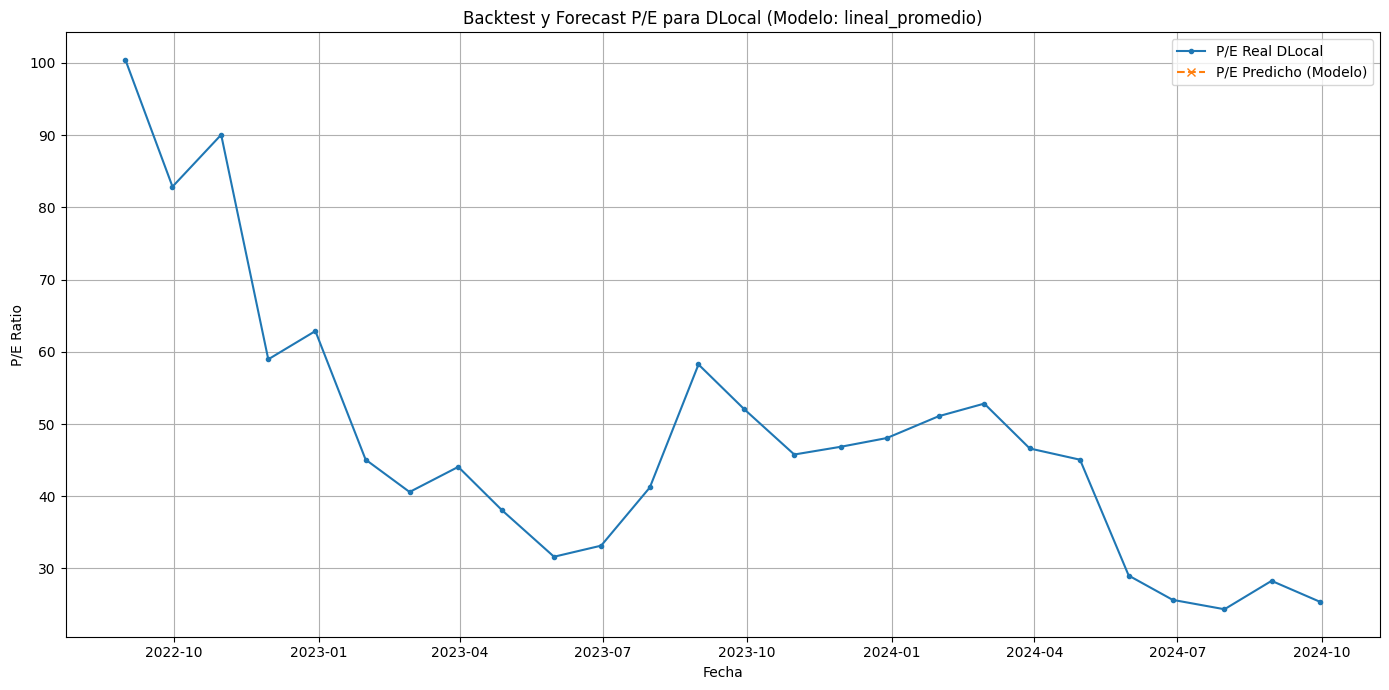

In [58]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time # Para medir tiempo
import joblib # Para cargar el modelo

# --- Modelos (Solo necesarios si el pipeline no los incluye serializados) ---
# from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor

# --- Métricas y Preprocesamiento ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import BaseCrossValidator, train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
# --- IMPORTACIONES PARA TRANSFORMACIONES (Si las usaras en el futuro) ---
# from sklearn.preprocessing import PowerTransformer, QuantileTransformer
# from scipy.stats import boxcox
# from scipy.special import inv_boxcox
# ------------------------------------

# Ignorar warnings comunes (opcional)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
pd.options.mode.chained_assignment = None

# =====================================
# FUNCIONES AUXILIARES (Requeridas por el código)
# =====================================
def rmse(y_true, y_pred):
    """Calcula RMSE manejando NaNs/Infs."""
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if not np.all(mask): y_true, y_pred = y_true[mask], y_pred[mask]
    if len(y_true) == 0: return np.nan
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_model(y_test, y_pred):
    """ Retorna métricas manejando NaNs/Infs."""
    y_test, y_pred = np.asarray(y_test), np.asarray(y_pred)
    mask = np.isfinite(y_test) & np.isfinite(y_pred)
    if not np.all(mask): y_test, y_pred = y_test[mask], y_pred[mask]
    if len(y_test) == 0: return {'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan}
    mae = mean_absolute_error(y_test, y_pred); rmse_val = rmse(y_test, y_pred)
    r2 = np.nan
    if np.var(y_test) > 1e-9:
         try: r2 = r2_score(y_test, y_pred)
         except ValueError: pass
    elif mean_squared_error(y_test, y_pred) < 1e-9: r2 = 1.0
    else: r2 = 0.0
    return {'RMSE': rmse_val, 'MAE': mae, 'R2': r2}

class DropColumns(BaseEstimator, TransformerMixin):
    """Transformer para eliminar columnas especificadas en un Pipeline."""
    def __init__(self, columns=None): self.columns = columns
    def fit(self, X, y=None): return self
    def transform(self, X):
        if not isinstance(X, pd.DataFrame): return X
        return X.drop(columns=self.columns, errors='ignore')

# =====================================
# BLOQUE DE PREDICCIÓN PARA DLOCAL (CORREGIDO - SIN BFILL PRE-LAG)
# =====================================

# --- CONFIGURACIÓN ---
# ASUME df_dlocal: DataFrame cargado y con preprocesamiento inicial
# ASUME listas_columnas: Diccionario {metodo: [lista_cols_base]}
# ASUME que el mejor modelo fue entrenado con transformación logarítmica y dropna

use_log_transform = True # ¡¡ASEGÚRATE de que esto coincida con cómo entrenaste el modelo cargado!!
metodo_modelo_cargado = 'lineal_promedio' # <-- ¡¡AJUSTA ESTO AL MÉTODO DE TU MEJOR MODELO!!
nombre_archivo_modelo = "best_pipeline_model_.pkl" # <-- ¡¡PONE EL NOMBRE CORRECTO DE TU ARCHIVO GUARDADO!!

# --- Verificar Inputs Necesarios ---
if 'df_dlocal' not in locals() or not isinstance(df_dlocal, pd.DataFrame):
     raise NameError("El DataFrame 'df_dlocal' no está definido.")
if 'listas_columnas' not in locals() or not isinstance(listas_columnas, dict):
     raise NameError("El diccionario 'listas_columnas' no está definido.")
if metodo_modelo_cargado not in listas_columnas:
    raise ValueError(f"El método '{metodo_modelo_cargado}' no se encuentra en listas_columnas.")
# ---------------------------------

print("="*60)
print(f"Preparando datos de DLocal para predicción (Método: {metodo_modelo_cargado})")
print("="*60)

# --- 1. Preparar df_dlocal con Lags (usando dropna) ---
df_dlocal_preparado = df_dlocal.copy()

# --- 1.1 Forzar Conversión Numérica ---
columnas_base_modelo_pe = listas_columnas[metodo_modelo_cargado]
columnas_a_convertir = [c for c in columnas_base_modelo_pe if c not in ['Empresa', 'Fecha']]
columnas_a_convertir_existentes = [c for c in columnas_a_convertir if c in df_dlocal_preparado.columns]
print(f"Forzando {len(columnas_a_convertir_existentes)} columnas a numérico en DLocal...")
for col in columnas_a_convertir_existentes:
    if not pd.api.types.is_numeric_dtype(df_dlocal_preparado[col]):
        df_dlocal_preparado[col] = pd.to_numeric(df_dlocal_preparado[col], errors='coerce')

# --- 1.2 Imputar NaNs PRE-LAG usando FFILL + FILLNA(0) ---
print("Imputando NaNs pre-lag con ffill + fillna(0)...")
cols_imputar_prelag = [c for c in df_dlocal_preparado.columns if c not in ['Empresa', 'Fecha']]
cols_imputar_prelag_existentes = [c for c in cols_imputar_prelag if c in df_dlocal_preparado.columns]
df_dlocal_preparado.sort_values(['Empresa', 'Fecha'], inplace=True)
# Aplicar ffill por grupo (asumiendo que df_dlocal solo tiene una 'Empresa')
if df_dlocal_preparado['Empresa'].nunique() > 1:
     df_dlocal_preparado[cols_imputar_prelag_existentes] = df_dlocal_preparado.groupby('Empresa')[cols_imputar_prelag_existentes].ffill()
else:
     df_dlocal_preparado[cols_imputar_prelag_existentes] = df_dlocal_preparado[cols_imputar_prelag_existentes].ffill()
# Rellenar NaNs restantes (iniciales) con 0
nans_post_ffill = df_dlocal_preparado[cols_imputar_prelag_existentes].isnull().sum().sum()
if nans_post_ffill > 0:
    print(f"    {nans_post_ffill} NaNs restantes después de ffill. Rellenando con 0.")
    df_dlocal_preparado.fillna(0, inplace=True) # Relleno global final
else:
    print("    No quedan NaNs después de ffill.")
# --- NO SE USA BFILL ---

# --- 1.3 Seleccionar Columnas y Generar Lag 1 ---
columnas_base_modelo = [c for c in listas_columnas[metodo_modelo_cargado] if c != 'P_E']
cols_necesarias_dlocal = ['Empresa', 'Fecha', 'P_E'] + [c for c in columnas_base_modelo if c in df_dlocal_preparado.columns]
df_dlocal_filtrado = df_dlocal_preparado[cols_necesarias_dlocal].copy()

predictors_dlocal = []
print(f"  Generando lag 1 para {len(columnas_base_modelo)} features base...")
for col_base in columnas_base_modelo:
    if col_base in df_dlocal_filtrado.columns:
        lag_col_name = f"{col_base}_lag1"
        # Usar groupby aunque sea una empresa para consistencia
        df_dlocal_filtrado[lag_col_name] = df_dlocal_filtrado.groupby('Empresa')[col_base].shift(1)
        predictors_dlocal.append(lag_col_name)

# --- 1.4 Aplicar dropna ---
print("  Aplicando dropna() a las columnas de lag...")
rows_before = len(df_dlocal_filtrado)
df_dlocal_lagged = df_dlocal_filtrado.dropna(subset=predictors_dlocal).copy()
rows_after = len(df_dlocal_lagged)
print(f"  Se eliminaron {rows_before - rows_after} filas.")
print(f"  Shape final de datos DLocal con lags: {df_dlocal_lagged.shape}")

if df_dlocal_lagged.empty:
    raise ValueError("El DataFrame de DLocal quedó vacío después de calcular lags y aplicar dropna.")

# Añadir time_step si falta (para consistencia con entrenamiento, aunque no se use en predict)
if 'time_step' not in df_dlocal_lagged.columns:
    df_dlocal_lagged.sort_values(['Empresa', 'Fecha'], inplace=True)
    df_dlocal_lagged['time_step'] = df_dlocal_lagged.groupby('Empresa').cumcount()

# --- 2. Cargar el Modelo Entrenado ---
print(f"\nCargando modelo entrenado desde: {nombre_archivo_modelo}")
try:
    loaded_best_pipeline = joblib.load(nombre_archivo_modelo)
    print("Modelo cargado exitosamente.")
except FileNotFoundError:
    raise FileNotFoundError(f"Error: No se encontró el archivo del modelo '{nombre_archivo_modelo}'.")
except Exception as e_load:
    raise RuntimeError(f"Error al cargar el modelo: {e_load}")

# --- 3. Obtener Features Esperadas por el Modelo Cargado ---
print("\nVerificando modelo cargado y features esperadas...")
expected_features = None
try:
    final_model = None
    if hasattr(loaded_best_pipeline, 'steps'):
        final_model = loaded_best_pipeline.steps[-1][1]
    elif hasattr(loaded_best_pipeline, 'feature_names_in_'):
        final_model = loaded_best_pipeline

    if final_model and hasattr(final_model, 'feature_names_in_'):
        expected_features = list(final_model.feature_names_in_)
        print(f"Modelo cargado espera {len(expected_features)} features.")
    elif final_model and hasattr(final_model, 'n_features_in_'):
         num_expected = final_model.n_features_in_
         print(f"Modelo cargado espera {num_expected} features (nombres no disponibles).")
         expected_features = sorted([p for p in predictors_dlocal if p in df_dlocal_lagged.columns])
         if len(expected_features) != num_expected: print(f"¡ADVERTENCIA! Discrepancia features: Modelo={num_expected}, Generadas={len(expected_features)}.")
         print(f"Usando {len(expected_features)} features generadas.")
    else:
         print("\nAdvertencia: No se pudo determinar las features esperadas. Usando todas las _lag1 generadas.")
         expected_features = sorted([p for p in predictors_dlocal if p in df_dlocal_lagged.columns])
         if not expected_features: raise ValueError("No se pudieron determinar las features.")
         print(f"Intentando usar {len(expected_features)} features generadas.")

    missing_features_for_pred = [f for f in expected_features if f not in df_dlocal_lagged.columns]
    if missing_features_for_pred:
        raise ValueError(f"Faltan features requeridas en DLocal: {missing_features_for_pred}")
    print("Todas las features esperadas están presentes.")

except Exception as e_model_check:
    raise ValueError(f"Error al verificar el modelo cargado: {e_model_check}")


# --- 4. Predicción One-Step Ahead Retrospectiva y Forecast ---
print("\n" + "="*60)
print("Predicción One-Step Ahead para DLocal")
print("="*60)

n_rows = len(df_dlocal_lagged)
fechas_pred = []
predicciones = []
valores_reales = []

if n_rows < 1:
    print("No hay suficientes filas en df_dlocal_lagged para hacer predicciones.")
else:
    # Bucle retrospectivo
    print(f"Realizando {n_rows-1} predicciones retrospectivas...")
    for i in range(1, n_rows):
        features_input_row = df_dlocal_lagged.iloc[[i-1]]
        X_pred = features_input_row[expected_features] # Seleccionar SOLO las features esperadas

        try:
            pred_raw = loaded_best_pipeline.predict(X_pred)[0]
            if use_log_transform:
                with np.errstate(over='ignore', invalid='ignore'): pred_orig = np.expm1(pred_raw)
                if not np.isfinite(pred_orig): pred_orig = np.nan
            else:
                pred_orig = pred_raw
            predicciones.append(pred_orig)
            fechas_pred.append(df_dlocal_lagged.iloc[i]['Fecha'])
            valores_reales.append(df_dlocal_lagged.iloc[i]['P_E'])
        except Exception as e_pred:
            print(f"Error prediciendo para fila {i} (Fecha: {df_dlocal_lagged.iloc[i]['Fecha']}): {e_pred}")
            predicciones.append(np.nan)
            fechas_pred.append(df_dlocal_lagged.iloc[i]['Fecha'])
            valores_reales.append(df_dlocal_lagged.iloc[i]['P_E'])

    # Forecast para el siguiente período
    print("Generando forecast para el próximo período...")
    features_ultimo = df_dlocal_lagged.iloc[[-1]]
    X_pred_ultimo = features_ultimo[expected_features] # Seleccionar SOLO las features esperadas
    pronostico_next = np.nan # Default

    try:
        pronostico_next_raw = loaded_best_pipeline.predict(X_pred_ultimo)[0]
        if use_log_transform:
            with np.errstate(over='ignore', invalid='ignore'): pronostico_next = np.expm1(pronostico_next_raw)
            if not np.isfinite(pronostico_next): pronostico_next = np.nan
        else:
            pronostico_next = pronostico_next_raw
    except Exception as e_forecast:
        print(f"Error durante el forecast: {e_forecast}")

    # Estimar la fecha del próximo período
    try:
        proxima_fecha = df_dlocal_lagged['Fecha'].iloc[-1] + pd.DateOffset(months=1)
    except:
        proxima_fecha = "Periodo Siguiente"

    # --- Crear DataFrames de Resultados ---
    df_backtest = pd.DataFrame({'Fecha': fechas_pred, 'P_E_Predicho': predicciones, 'P_E_Real': valores_reales})
    df_forecast = pd.DataFrame({'Fecha': [proxima_fecha], 'P_E_Predicho': [pronostico_next]})

    # --- Mostrar Resultados ---
    print("\n--- Resultados del Backtest para DLocal ---")
    with pd.option_context('display.max_rows', None):
         print(df_backtest.to_string(float_format="%.4f"))
    print(f"\n--- Pronóstico para {proxima_fecha} ---")
    print(df_forecast.to_string(float_format="%.4f"))

    # --- Calcular Métricas del Backtest ---
    print("\n--- Métricas del Backtest (DLocal) ---")
    metricas_dlocal = evaluate_model(df_backtest['P_E_Real'], df_backtest['P_E_Predicho'])
    print(f"RMSE: {metricas_dlocal['RMSE']:.4f}")
    print(f"MAE:  {metricas_dlocal['MAE']:.4f}")
    print(f"R2:   {metricas_dlocal['R2']:.4f}")

    # --- Graficar Resultados ---
    plt.figure(figsize=(14, 7))
    plt.plot(df_backtest['Fecha'], df_backtest['P_E_Real'], marker='.', linestyle='-', label='P/E Real DLocal')
    plt.plot(df_backtest['Fecha'], df_backtest['P_E_Predicho'], marker='x', linestyle='--', label='P/E Predicho (Modelo)')
    if isinstance(proxima_fecha, pd.Timestamp) and pd.notna(pronostico_next): # Graficar solo si es válido
         plt.scatter([proxima_fecha], [pronostico_next], color='red', label=f'Forecast {proxima_fecha.strftime("%Y-%m")}', zorder=5, s=100)
    plt.title(f'Backtest y Forecast P/E para DLocal (Modelo: {metodo_modelo_cargado})')
    plt.xlabel('Fecha'); plt.ylabel('P/E Ratio'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()